In [1]:
import pandas as pd 
from matplotlib import pyplot as plt

In [8]:
subs=pd.read_pickle('Datasets/submissions.pickle')
subs=subs[subs.index.date.astype(str)!='2021-07-01']

# Filtering on top Score per day

In [12]:
subs['date_str']=subs.index.date.astype(str)
#take only Bitcoin and btc subreddits
bit=subs[subs.subreddit.isin(['Bitcoin','btc'])]

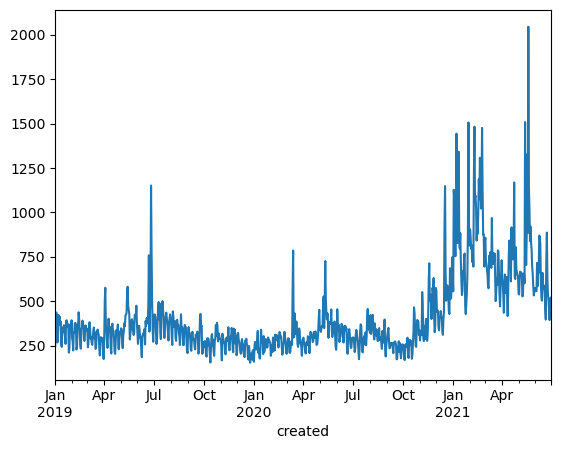

In [13]:
bit.resample('d').id.count().plot()
plt.show()

In [14]:
# Top Submission per N days by Score
topN=bit.groupby('date_str',group_keys=False).apply(lambda x: x.nlargest(100, 'score'))


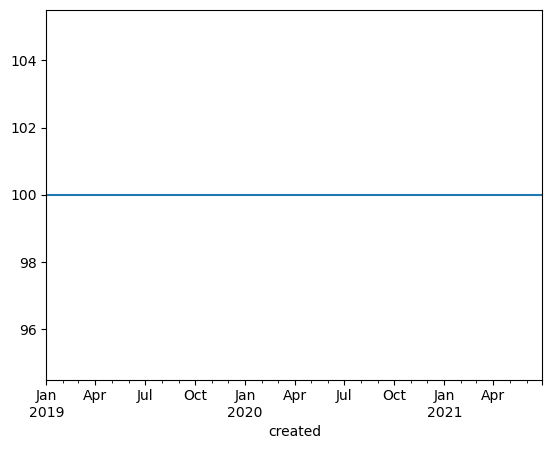

In [15]:
topN.resample('d').id.count().plot()
plt.show()

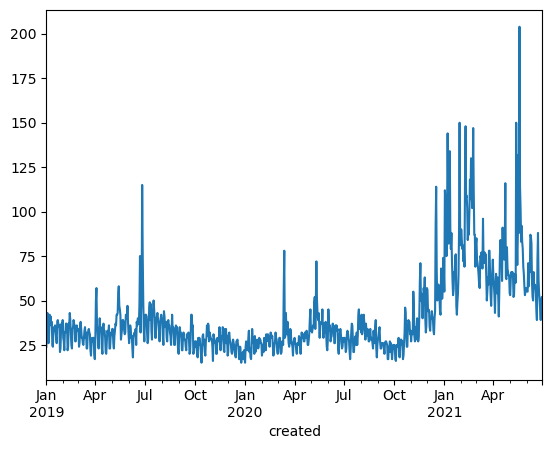

In [16]:
top10pct=bit.groupby('date_str',group_keys=False).apply(lambda x: x.nlargest(int(len(x) * 0.1), 'score')).sort_index()
top10pct.resample('d').id.count().plot()
plt.show()

In [20]:
top10pct.shape[0]

37025

In [18]:
from tqdm import tqdm
tqdm.pandas()
#from GitHub_Repo.CryptoSent.cs_models.distilbert import distil_bert_df
from GitHub_Repo.CryptoSent.cs_models.finbertlong import fin_bert_long

In [24]:
top10pct['fb_long']=top10pct.clean_text.progress_apply(fin_bert_long)

100%|██████████| 37025/37025 [2:55:36<00:00,  3.51it/s]


In [25]:
top10pct.to_pickle('fb_top10.pickle')

In [28]:
top10pct['sent_fb_long']=top10pct.fb_long.progress_apply(lambda x: x[0]-x[1])

100%|██████████| 37025/37025 [00:00<00:00, 962902.99it/s]


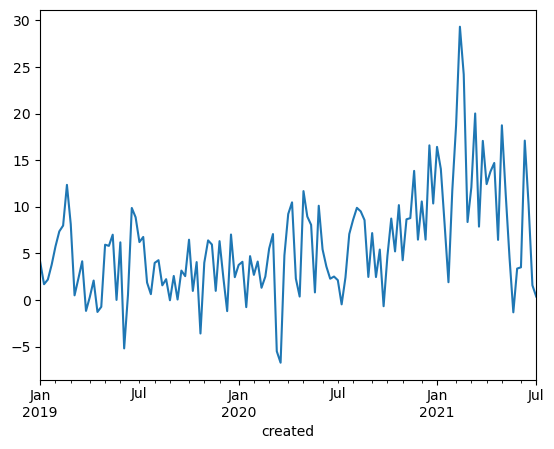

In [31]:
top10pct.resample('w').sent_fb_long.sum().plot()
plt.show()

In [ ]:
top10pct=distil_bert_df(top10pct,text='clean_text',output_type='sentiment') # 1.5 hours
top10pct.to_pickle('db_top10.pickle')

## Posts that contain btc or Bitcoin

In [33]:
btcbit=subs[subs.clean_text.str.contains('|'.join(['btc','bitcoin']))]
top10pctbtcbit=btcbit.groupby('date_str',group_keys=False).apply(lambda x: x.nlargest(int(len(x) * 0.1), 'score')).sort_index()


In [38]:
top10pctbtcbit['fb_long']=top10pctbtcbit.clean_text.progress_apply(fin_bert_long)
top10pctbtcbit.to_pickle('fb_top10_keyword.pickle')

100%|██████████| 38760/38760 [2:40:23<00:00,  4.03it/s]


In [39]:
btcbit=subs[subs.clean_text.str.contains('|'.join(['btc','bitcoin']))]
top10pctbtcbit=btcbit.groupby('date_str',group_keys=False).apply(lambda x: x.nlargest(int(len(x) * 0.1), 'score')).sort_index()
top10pctbtcbit=distil_bert_df(top10pctbtcbit,text='clean_text',output_type='sentiment')
top10pctbtcbit.to_pickle('db_top10_keyword.pickle')


# Merging Top Score Splits

In [3]:
m1=pd.read_pickle('db_top10.pickle')
m2=pd.read_pickle('db_top10_keyword.pickle')
m3=pd.read_pickle('fb_top10.pickle')
m4=pd.read_pickle('fb_top10_keyword.pickle')
maindf=pd.read_pickle('Datasets/submissions.pickle')

m1['origin']='top10_percent'
m2['origin']='top10_percent'
m3['origin']='top10_percent'
m4['origin']='top10_percent'

maindf['origin']='main'
mdb=pd.concat([m1,m2]).drop_duplicates(subset='id')
mfb=pd.concat([m3,m4]).drop_duplicates(subset='id')
msent=mdb.merge(mfb[['id','fb_long']],on='id',how='left')
mergedf=pd.concat([msent,maindf]).drop_duplicates(subset='id')

In [83]:
#mergedf.to_pickle('submissions_raw_save.pickle')

In [119]:
mergedf=pd.read_pickle('submissions_raw_save.pickle')
mergedf['sent_lr']=mergedf.sentiment_scores_lr_v2.apply(lambda x: x[0]-x[1])
mergedf.sent_db=mergedf.sent_db.replace('no_score',0).fillna(0)
mergedf.fb_long=mergedf.fb_long.replace('no_score',0).fillna(0)
mergedf.index=mergedf.created
mergedf.fb_long=mergedf.fb_long.apply(lambda x: x[0]-x[1] if not isinstance(x, int) else 0)
mergedf=mergedf.rename(columns={'fb_long':'sent_fb'})\
       [['author', 'num_comments', 'score', 'title', 'selftext', 'award_name',
       'award_description', 'award_count', 'award_coin_price',
       'award_coin_reward', 'subreddit', 'subreddit_subscribers', 'id',
       'domain', 'no_follow', 'send_replies', 'author_fullname',
       'subreddit_id', 'permalink', 'url', 'created', 'author_created',
       'clean_text',  'origin','sent_db', 'sent_fb', 'sent_lr']]
mergedf.loc[(mergedf.subreddit.isin(['Bitcoin','btc']))|(mergedf.clean_text.str.contains('bitcoin','btc')),'topic']='Bitcoin'       
#mergedf=mergedf.drop(columns=['text_processed','all_text','sentiment_scores_lr','polarity_lr','sentiment_lr','date_str','sentiment_scores_lr_v2'])

In [121]:
#mergedf.to_pickle('Datasets/submissions.pickle')

# Filter on Experts

In [14]:
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np
from tqdm import tqdm
tqdm.pandas()

def get_awards_kpi(df):
    df.award_count=df.award_count.replace('Empty',0)
    df.award_coin_price=df.award_coin_price.replace('Empty',0)
    df['kpi1']=df.apply(lambda row: row['award_count']*row['award_coin_price'] if type(row['award_count'])==int
                                            else sum(np.multiply(np.array(list(row['award_count'])),np.array(list(row['award_coin_price'])))),axis=1)

    #top_authors=df[df.author!='[deleted]'].sort_values(by='kpi1',ascending=False).head(1000).author.unique().tolist()
    #return top_authors
    #top_authors_df=top[top.author.isin(get_experts(top))]

    


In [ ]:
subs=pd.read_pickle('Datasets/submissions.pickle')
btc=subs[subs.topic=='Bitcoin']

In [2]:

ta1=btc[(btc.origin!='main')&(btc.author!='[deleted]')].author.unique().tolist()
ta2=btc.groupby('author').id.count().sort_values(ascending=False).tail(-1).head(10000).index.tolist()
ta=pd.DataFrame((ta1+ta2),columns=['top_authors']).drop_duplicates()


In [3]:
from GitHub_Repo.CryptoSent.tools.utils import access_reddit
r=access_reddit()

def get_karma(author,reddit_conector):
    try:
        return reddit_conector.redditor(author).total_karma
    except:
        return 0

In [4]:
ta['karma']=ta.top_authors.progress_apply(lambda x: get_karma(x,r))
ta.to_pickle('karma.pickle')

100%|██████████| 21181/21181 [5:51:01<00:00,  1.01it/s]


In [15]:
karmadf=pd.read_pickle('karma.pickle')
author_to_karma=karmadf.set_index('top_authors').to_dict()['karma']
subs['author_karma']=subs.author.map(author_to_karma)
get_awards_kpi(subs)
subs['author_posts']=subs.groupby('author').id.transform('count') # number of posts per author
subs['num_awards']=subs.award_count.apply(lambda x: len if not isinstance(x,int) else 0) # number of awards per post

In [29]:
coms=pd.read_pickle('Datasets/comments.pickle')

In [61]:
coms['sent_lr']=coms.sentiment_scores_lr.progress_apply(lambda x: x[1]-x[0])
coms['submission_id']=coms.parent_id.progress_apply(lambda x: x.split('_')[1])
coms1=coms[coms.submission_id.isin(subs.id.unique().tolist())]
subid_to_sent_com=coms1.groupby('submission_id').sent_lr.sum().to_dict()
subs['sent_lr_coms']=subs.id.map(subid_to_sent_com)

100%|██████████| 15061011/15061011 [00:13<00:00, 1125838.97it/s]


In [66]:
#subs.to_pickle('Datasets/submissions.pickle')

# NTUSD Sentiment Addition

In [70]:
ntword=pd.read_json('Datasets/NTUSD_Fin_word_v1.0.json')
ntemoji=pd.read_json('Datasets/NTUSD_Fin_emoji_v1.0.json')
nthastag=pd.read_json('Datasets/NTUSD_Fin_hashtag_v1.0.json')
word2sent=ntword.set_index('token').market_sentiment.to_dict()
emoji2sent=ntemoji.set_index('token').market_sentiment.to_dict()

In [96]:
def get_ntusd_score(text):
    score=0
    for token in text.split():
        if token in word2sent:
            score=score+word2sent[token]
        if token in emoji2sent:
            score=score+emoji2sent[token]
    return score

In [108]:
coms['sent_ntusd']=coms.body_clean.progress_apply(get_ntusd_score)

100%|██████████| 15061011/15061011 [01:05<00:00, 228297.69it/s]


In [109]:
#coms.to_pickle('Datasets/comments.pickle')

In [112]:
subs['sent_ntusd']=subs.clean_text.progress_apply(get_ntusd_score)
coms1=coms[coms.submission_id.isin(subs.id.unique().tolist())]
subid_to_sent_com_ntusd=coms1.groupby('submission_id').sent_ntusd.sum().to_dict()
subs['sent_ntusd_coms']=subs.id.map(subid_to_sent_com_ntusd)

subs=subs.rename(columns={'kpi1':'awards_value'})
#subs.to_pickle('Datasets/submissions.pickle')

100%|██████████| 1559351/1559351 [00:08<00:00, 190459.84it/s]


# Sell Buy Baseline Addition


In [183]:
subs=pd.read_pickle('Datasets/submissions.pickle')
subs.loc[subs.clean_text.str.contains('sell'),'sell']=True
subs.loc[subs.clean_text.str.contains('buy'),'buy']=True
subs.sell=subs.sell.fillna(False)
subs.buy=subs.buy.fillna(False)
#subs.to_pickle('Datasets/submissions.pickle')


In [192]:
subs.clean_text.sample(10)

created
2019-12-20 13:03:50    address generational need high speed payment s...
2021-02-10 04:30:41                                            xlm steal
2019-02-08 23:42:33    litecoin foundation beam partner explore new p...
2019-08-06 20:19:51                     label china currency manipulator
2021-05-18 23:50:39    fan fairly critical don t think rocket pool id...
2021-06-24 00:43:32                            eao valuable project 2021
2019-10-29 02:30:51                  ltc usdt technical analysis binance
2019-03-24 09:56:32    tron trx voert vier update door cardano ada wi...
2020-10-27 14:29:53         like finance airdrop claim 500 like pre sale
2020-05-16 12:44:46                    justification bitcoin s marketcap
Name: clean_text, dtype: object